# Assignment Week 10: Text Mining using Dimensionality Reduction Methods

## Student ID: XXXXXXXX

This dataset comes from the website [Internet Movie Database](https://www.imdb.com/), and represents 1,000 reviews which were labeled (by humans) as positive or negative, see [here](http://ai.stanford.edu/~amaas/data/sentiment/) for more details. In this coursework, we will study how we can use dimensionality reduction methods to improve our understanding of text data and to predict the sentiment of a set of texts. This application of data science is called [sentiment analysis](https://en.wikipedia.org/wiki/Sentiment_analysis) and it is widely used across many fields to get automated feedback when text opinions are expressed. While most modern methods of sentiment analysis are using complex deep learning methods, the tools we have seen this week can be readily applied to get a good idea of what our users are expressing.

In [1]:
# Import other packages if you need them!
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import sklearn.feature_extraction.text as sktext
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score


# Plotting
import matplotlib.pyplot as plt 
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

## Data import

The dataset comes with the text and a binary variable which represents the sentiment, either positive or negative. The following code imports the data, splits it into train and test, and applies the [Tf-Idf transform](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) (see the lectures, slide 34).

In [2]:
# Be sure to first leave the data here!
imdb_data = pd.read_excel('IMDB_Sample.xlsx')


# Scikit-Learn works by first defining the der 
TfIDFTransformer = sktext.TfidfVectorizer(strip_accents='unicode', # Eliminate accents and special characters
                      stop_words='english', # Eliminates stop words.
                      min_df = 0.05, # Eliminate words that do not appear in more than 5% of texts
                      max_df = 0.95, # Eliminate words that appear in more than 95% of texts
                      sublinear_tf=True # Use sublinear weights (softplus)
                      )

# Train / test split
x_train, x_test, y_train, y_test = train_test_split(imdb_data['texts'],
                                                    imdb_data['class'],
                                                    test_size=0.3,
                                                    random_state=20210318)

# Calculate the Tf-Idf transform.
TfIDF_train = TfIDFTransformer.fit_transform(x_train)
TfIDF_test = TfIDFTransformer.transform(x_test)

# Turn to dense matrix as PCA does not like sparse ones.
TfIDF_train = TfIDF_train.toarray()
TfIDF_test = TfIDF_test.toarray()

From here on, you will use the variables `TfIDF_train` and `TfIDF_test` as the input for the different tasks, and the `y_train` and `y_test` labels for each dataset (if required).  The output is a **sparse matrix** with the 236 words that do not appear in more than 95% of texts nor in less than 5% of texts. These matrices only store the relevant information! They are *much* more efficient in-memory.  Sadly, PCA nor torch deal very well with sparse matrices without further processing, so we turn them into dense matrices.

We can check the outputs of the first row with the below code.

In [3]:
print(TfIDF_train[1,:])

[0.         0.         0.         0.         0.         0.16565558
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.24573797 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.17111284 0.
 0.         0.         0.         0.         0.17934085 0.
 0.18989355 0.         0.20293873 0.         0.         0.
 0.         0.         0.15861506 0.         0.28146216 0.15964171
 0.         0.         0.13397591 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.2143442  0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.11417021 0.
 0.         0.         0.         0.         0.19858848 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.1750

Each column represents one word and each non-zero value represents the Tf-IDF weight as seen in the lectures. To find out which word is which in the index, you can use the [`TfIDFTransformer.get_feature_names()` method](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html).

In [4]:
print('There are %i words in the index.' % len(TfIDFTransformer.get_feature_names()))

There are 236 words in the index.


## Task 1: PCA decomposition of the texts. [35 pts]

Now you have the TfIDF matrix, We can start working on the data. As a first step, we want to explore what some commonly occuring concepts in the text reviews. We can do this using PCA. A PCA transform of the TF-IDF matrix will give you a basis of the text data, each representing a *concept* or set of words that are correlated. Correlation in text can be interpreted as a relation to a similar topic.

1. First, calculate a PCA transform of the training data using the **maximum** number of concepts possible. Make a plot of the explained variance that shows the cumulative explained variance per number of concepts. 

**Written answer: Exactly how many concepts do you need to correctly explain at least 75% of the data? (note we need the exact # of concepts)**  [15 pts]

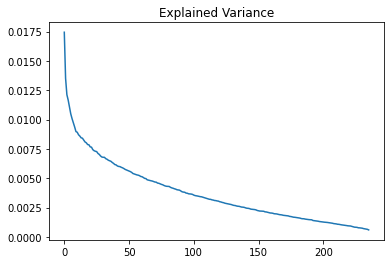

In [5]:
# Your code here.
PCA_q1 = PCA(n_components=236)
PCA_q1.fit(TfIDF_train)
# Make the plot
variance_q1 = PCA_q1.explained_variance_
plt.plot(variance_q1)
plt.title('Explained Variance')
plt.show()

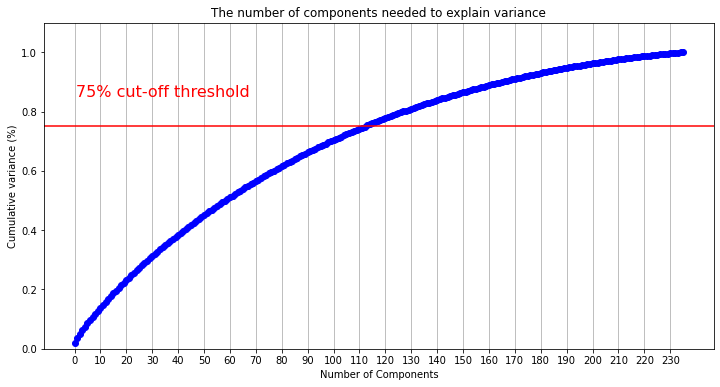

In [6]:
# To get the exact index where the variance is above 75%
PCA_q1_2 = PCA()
PCA_q1_2.fit(TfIDF_train)
plt.rcParams['figure.figsize'] = (12,6)
fig,ax = plt.subplots()
xi = np.arange(0, 236, step = 1)
variance_q1_2 = np.cumsum(PCA_q1_2.explained_variance_ratio_)
plt.ylim(0.0,1.1)
plt.plot(xi,variance_q1_2,marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 236, step =10)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.75, color='r', linestyle='-')
plt.text(0.5, 0.85, '75% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

**Written answer: ** we need 110 concepts

2. Study the first three concepts. To do this, show the 10 words that are the most important in the each of these three concepts (as revealed by the absolute value of the PCA weight in each concept).

**Written answer: What is the cumulative variance explained by these three concepts? What would you name each of these concepts?** [10 pts]
*Hint: if in a concept you would get the words 'dog', 'cat', 'fish' as the most important ones, you could name the concept 'animals' or 'pets'.*

In [8]:
# Explained variance.
PCA_q1_2.explained_variance_[:3]

cumulated_va = PCA_q1_2.explained_variance_[:3]
print("The cumulative variance by these three components are", PCA_q1_2.explained_variance_[:3])

The cumulative variance by these three components are [0.01744374 0.01350944 0.0121214 ]


In [27]:
# Get words per component
featured_names = TfIDFTransformer.get_feature_names()

In [33]:
# Concept 1
weight_con1 = PCA_q1_2.components_[0,]
weight_con1 = np.abs(weight_con1)

weight_con1_idx = np.argpartition(weight_con1, -10)[-10:]
weight_con1_idx = weight_con1.argsort()[-10:][::-1]

for num in weight_con1_idx:
    print(featured_names[num])

[134  67  15 135  68 111 219  18 223  50]
movie
film
bad
movies
films
like
watch
best
woman
don


In [35]:
# Concept 2
weight_con2 = PCA_q1_2.components_[1,]
weight_con2 = np.abs(weight_con2)

weight_con2_idx = np.argpartition(weight_con2, -10)[-10:]
weight_con2_idx = weight_con2.argsort()[-10:][::-1]

for num in weight_con2_idx:
    print(featured_names[num])

film
bad
films
series
way
great
like
story
love
say


In [36]:
# Concept 3
weight_con3 = PCA_q1_2.components_[2,]
weight_con3 = np.abs(weight_con3)

weight_con3_idx = np.argpartition(weight_con3, -10)[-10:]
weight_con3_idx = weight_con3.argsort()[-10:][::-1]

for num in weight_con3_idx:
    print(featured_names[num])

film
movie
series
man
old
funny
seen
star
acting
new


**Written answer: **

3. Apply the PCA transformation to the test dataset. Using only the first two components, make a scatter plot of the cases. Identify positive and negative cases by colouring points with different sentiments with different colours. 

**Written answer: What can you say about where the positive and negative cases lie in your plot? Could we use these concepts to discriminate positive and negative cases? If yes, why? If no, why not? Discuss your findings.** [10 pts]

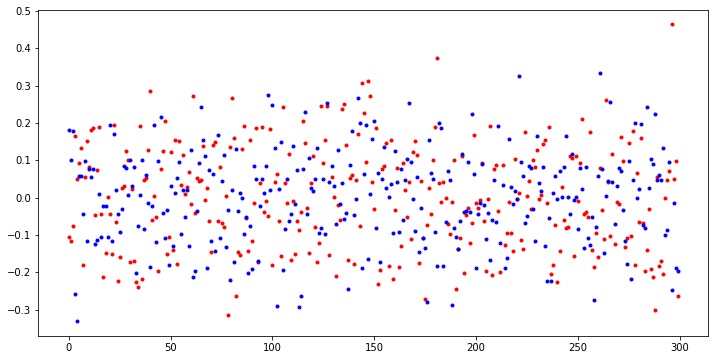

In [9]:
# Apply the test data
PCA_q1_3 = PCA(n_components=2)
PCA_q1_3.fit(TfIDF_test)
# Plot the two different set of points filtering by label.
princioalComp = PCA_q1_3.transform(TfIDF_test)
princioalComp_df = pd.DataFrame(data=princioalComp, columns= ['PC1', 'PC2'])
plt.plot(princioalComp_df.PC1, 'r.')
plt.plot(princioalComp_df.PC2, 'b.')

**Written answer:**

## Task 2: Autoencoders [35 pts]

We will see now the ability of autoencoders to compress the data. Train an autoencoder that compresses the data to 60 neurons in the encoding layer as shown in lab 10.2, to be trained over the original TfIDF train dataset. Use a total of 5 fully connected layers going from 236 to 100 to 60 to 100 to 236 units. Use a relu non-linearity for each of them. Then try at two more variations of this network. You could vary the number of hidden units, number of layers, or the type of nonlinearity that you are using. Train the models, each time reducing model reconstruction error. For each model you train, plot the reconstruction error (MSE) over the train set and the test set as you train every 100 rounds. 

**Written answer: Which of your models performs the best? After how many epochs does your best model reach convergence? Does your model overfit? If yes, why do you think this is? If no, why?** [10 pts each architecture plus 5 pts arguing which one is better plus the explaining of overfitting]

In [10]:
# Model architecture and definition
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(in_features=236, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=60),
            nn.ReLU(),
            nn.Linear(in_features=60, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=236),
            nn.ReLU(),
            nn.Linear(in_features=236, out_features=60),
            nn.ReLU(),
            )

        self.decoder = nn.Sequential(
            nn.Linear(60,236)
            )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

#build model
auto_enc_11 = autoencoder()

#define loss function
loss_fn = torch.nn.MSELoss()

#define learning rate
learning_rate = 1e-1


In [11]:
# Train!
TfIDF_traint_q2 = torch.from_numpy(TfIDF_train).float()
mse_list_train = []
for t in range (100):
  y_pred = auto_enc_11(TfIDF_traint_q2)
  loss = loss_fn(y_pred, TfIDF_traint_q2)
  auto_enc_11.zero_grad()
  if t % 10 == 9:
        print(t, loss.item())
  mse_list_train.append(loss.item())      
  auto_enc_11.zero_grad()
  loss.backward()
  with torch.no_grad():
        for param in auto_enc_11.parameters():
            param -= learning_rate * param.grad 

9 0.010607807897031307
19 0.0104591129347682
29 0.01031518541276455
39 0.010175750590860844
49 0.010040560737252235
59 0.009909390471875668
69 0.009782037697732449
79 0.009658307768404484
89 0.00953802838921547
99 0.009421058930456638


In [12]:
TfIDF_test_q2 = torch.from_numpy(TfIDF_test).float()
mse_list_test = []
for t in range (100):
  y_pred = auto_enc_11(TfIDF_test_q2)
  loss = loss_fn(y_pred, TfIDF_test_q2)
  auto_enc_11.zero_grad()
  if t % 10 == 9:
        print(t, loss.item())
  mse_list_test.append(loss.item())      
  auto_enc_11.zero_grad()
  loss.backward()
  with torch.no_grad():
        for param in auto_enc_11.parameters():
            param -= learning_rate * param.grad 

9 0.009328702464699745
19 0.009217333979904652
29 0.009108936414122581
39 0.009003285318613052
49 0.008900241926312447
59 0.008799693547189236
69 0.008701538667082787
79 0.008605686016380787
89 0.008512050844728947
99 0.008420554921030998


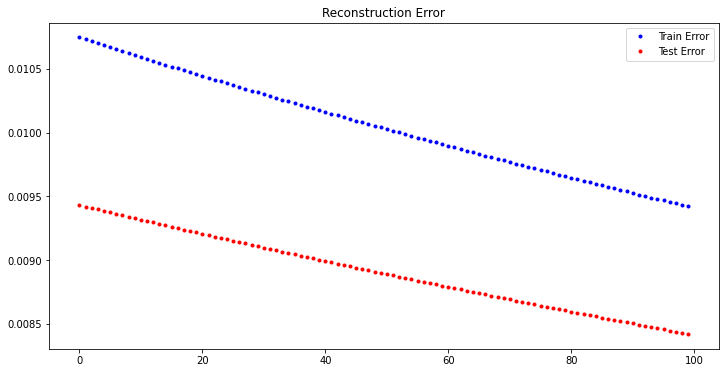

In [13]:
# Plot errors
plt.plot(mse_list_train, 'b.', label = 'Train Error')
plt.plot(mse_list_test, 'r.', label = 'Test Error')
plt.title('Reconstruction Error')
plt.legend()

**Written answer:**

## Task 3: Benchmarking predictive capabilities of the compressed data. [30 pts]

For the final task, you will benchmark the different compression algorithms over the original data. For this:

1. Train a regularized logistic regression over the original TfIDF train set (with no compression) to predict the positive / negative class label for each movie. Calculate the AUROC over the test set.
2. Train a regularized logistic regression over the PCA-reduced dataset (with 60 components), and calculate the AUROC over the PCA-transformed test set.
3. Train a regularized logistic regression over the encoded dataset (with 60 variables), and calculate AUROC over the encoded test set.

**Written answer 1: Compare the performance of the three models: how do they compare?**

**Written answer 2: Which of the two compression methods (methods 2 and 3) is better at compressing the data without altering its predictive capacity? Why do you think this happens?**

The AUROC score is 0.8621686532645437


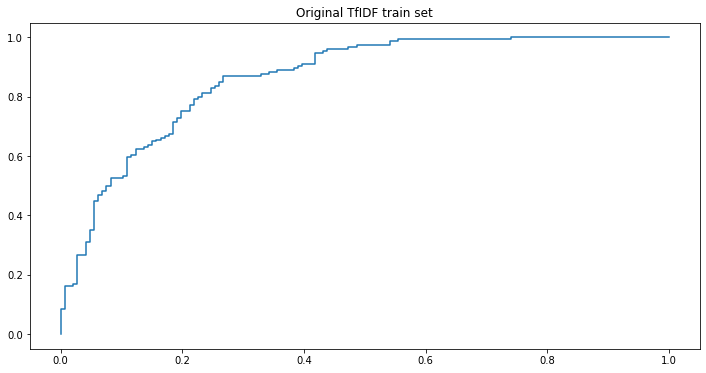

In [14]:
# Full dataset regression and AUC plot / calculation
reg = LogisticRegression()
reg.fit(TfIDF_train, y_train)
lr_probs = reg.predict_proba(TfIDF_test)
fpr, tpr, _ = roc_curve(y_test, lr_probs[:,1], pos_label=1)
fig,ax=plt.subplots()
ax.plot(fpr,tpr)
plt.title('Original TfIDF train set')
lr_auc = roc_auc_score(y_test, lr_probs[:,1])
print('The AUROC score is', lr_auc)

The AUROC score is 0.7265611101227539


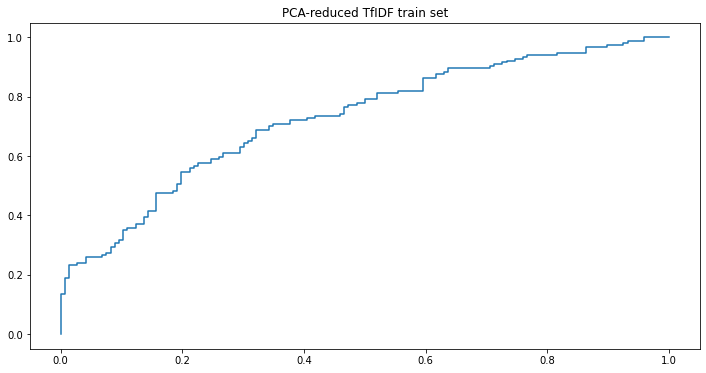

In [15]:
# PCA dataset regression and AUC plot / calculation
pca_q3 = PCA(n_components= 60)
pca_q3.fit(TfIDF_train)
TfIDF_train_t2 = pca_q3.transform(TfIDF_train)

reg.fit(TfIDF_train_t2, y_train)
pca_q3.fit(TfIDF_test)
TfIDF_test_t2 = pca_q3.transform(TfIDF_test)

lr_probs = reg.predict_proba(TfIDF_test_t2)
fpr, tpr, _ = roc_curve(y_test, lr_probs[:,1], pos_label=1)
fig,ax=plt.subplots()
ax.plot(fpr,tpr)
plt.title('PCA-reduced TfIDF train set')
lr_auc = roc_auc_score(y_test, lr_probs[:,1])
print('The AUROC score is', lr_auc)

In [16]:
class autoencoder1(nn.Module):
    def __init__(self):
        super(autoencoder1, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(in_features=236, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=60),
            nn.ReLU(),
            nn.Linear(in_features=60, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=236),
            nn.ReLU(),
            nn.Linear(in_features=236, out_features=60),
            nn.ReLU(),
            )

    def forward(self, x):
        x = self.encoder(x)
        return x


auto_enc_1 = autoencoder1()

The AUROC score is 0.46984522326988076


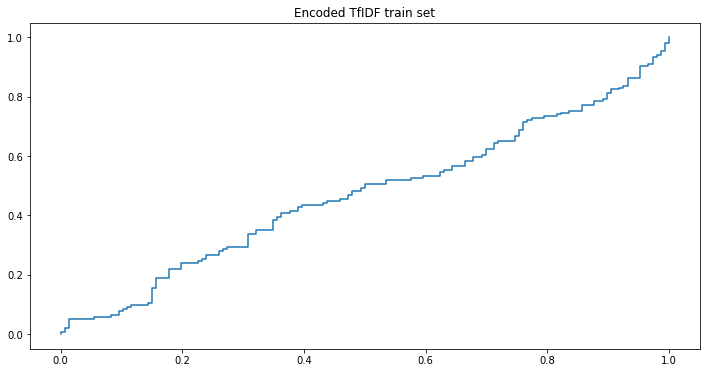

In [17]:
# Autoencoder dataset regression and AUC plot / calculation
TfIDF_traint_t3 = torch.from_numpy(TfIDF_train)
TfIDF_traint_t3 = auto_enc_1(TfIDF_traint_t3.float())
reg.fit(TfIDF_train_t2, y_train)

TfIDF_test_t3 = torch.from_numpy(TfIDF_test)
TfIDF_test_t3 = auto_enc_1(TfIDF_test_t3.float())

lr_probs = reg.predict_proba(TfIDF_test_t3.detach().numpy())
fpr, tpr, _ = roc_curve(y_test, lr_probs[:,1], pos_label=1)
fig,ax=plt.subplots()
ax.plot(fpr,tpr)
plt.title('Encoded TfIDF train set')
lr_auc = roc_auc_score(y_test, lr_probs[:,1])
print('The AUROC score is', lr_auc)

**Written answer:** We could compare the AUROC score and the plot as well. Encoded model is a better fit since it has a lower AUROC rate